# Book Recommendation System

This notebook is a collection of recommender systems for books. This was initially built on colab. Please read readme for further details

## Data Loading

In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.4 MB/s eta 0:00:00
time: 337 µs (started: 2023-10-31 09:18:01 +00:00)


In [ ]:
import time
time_list = []
tic = time.time()
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


u_cols = ['user_id', 'location', 'age']
users = pd.read_csv('/content/drive/Shareddrives/Books_Challenge/BX-Users.csv', sep=';',skiprows=1, names=u_cols, encoding='latin-1',low_memory=False)
users.head()

b_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
books = pd.read_csv('/content/drive/Shareddrives/Books_Challenge/BX-Books.csv', sep=';',skiprows=1, names=b_cols, encoding='latin-1',low_memory=False,on_bad_lines='warn')
books.head()

r_cols = ['user_id', 'isbn', 'rating']
ratings = pd.read_csv('/content/drive/Shareddrives/Books_Challenge/BX-Book-Ratings.csv',skiprows=1, sep=';', names=r_cols, encoding='latin-1',low_memory=False)
ratings.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9
Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9
Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9
Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9



,user_id,isbn,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## Utils

In [ ]:
def perform_eda(data):
    # Summary statistics
    summary = data.describe()
    # Missing values
    missing_values = data.isnull().sum()
    # Data types
    data_types = data.dtypes
    # Unique values
    unique_values = data.nunique()


    # Print results
    print("Summary Statistics:\n", summary)
    print("\nMissing Values:\n", missing_values)
    print("\nData Types:\n", data_types)
    print("\nUnique Values:\n", unique_values)
    print("\nShape of data:\n", data.shape)

def remove_non_letters(text):
    return re.sub('[^a-zA-Z]', '', text)

def recommend_isbn(book_name):
    book_isbn = books[books['book_title'] == book_name]['isbn'].iloc[0]
    return_list = []
    index = np.where(pt.index==book_isbn)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:10]
    for item in similar_items:
        isbn = pt.index[item[0]]
        return_list.append(books[books['isbn'] == isbn]['book_title'].iloc[0])

    return return_list

def get_best_book_cosine_colab(query ):
  try:
    series = similarity_scores[title_isbn_map[query]]
    return(isbn_title_map[series.sort_values().index[-2]])
  except:
    return ''

def get_all_book_cosine_colab(query ):
  try:
    series = similarity_scores[title_isbn_map[query]]
    return(series.sort_values())
  except:
    return ''

def get_best_book_graph_with_cosine_colab(query ):
  try:
    community = int(final_community_df[final_community_df.book_title==query][	'Community of Book'])
    community_book_list = final_community_df[final_community_df['Community of Book'] == community].book_title.to_list()
    similarity_list_ascending = get_all_book_cosine_colab(query).index.to_list()

    for i in [isbn_title_map[x] for x in list(reversed(similarity_list_ascending))[1:]]:
      if i in community_book_list:
        return(i)
        break
  except: return''



time: 1.51 ms (started: 2023-10-31 09:18:01 +00:00)


## Data Cleaning Pipeline

In [ ]:
users['age'] = users['age'].astype(float)
users['user_id'] = users['user_id'].astype(int)
users['location'] = users['location'].apply(lambda x: x.split(',') if len(x.split(','))==3 else ['n/a', 'n/a', 'n/a'])
users['city'] = users['location'].apply(lambda x: x[0].lower())
users['state'] = users['location'].apply(lambda x: x[1].lower())
users['country'] = users['location'].apply(lambda x: x[2].lower())
users.drop(['location', 'age'], axis = 1, inplace=True)



ratings['user_id'] = ratings['user_id'].astype(int)
ratings['rating'] = ratings['rating'].astype(int)


books['year_of_publication'] = books['year_of_publication'].apply(lambda s: int(s) if s.isdigit() else 2000)
books['book_title_identifier'] = books['book_title'].apply(lambda x: remove_non_letters(x).lower()) + books['book_author'].apply(lambda x: str(x).lower().split(' ')[-1])
print('Orignal book count', books.shape[0])
print('Actual book count', len(books['book_title_identifier'].unique()))
duplicates = books[books.duplicated(subset='book_title_identifier', keep=False)].groupby('book_title_identifier').apply(lambda x: x['isbn'].tolist()).to_dict()
books.drop_duplicates(subset='book_title_identifier', inplace=True)


correction_dict = {}  #{Incorrect ISBN: Correct ISBN}
for li in duplicates.values():
    correct_isbn = li[0]
    for incorrect_isbn in li[1:]:
        correction_dict[incorrect_isbn] = correct_isbn

print('Orignal ratings count', ratings.shape[0])
ratings['isbn'] = ratings['isbn'].map(correction_dict).fillna(ratings['isbn'])
ratings = ratings.groupby(['isbn', 'user_id']).max().reset_index()
print('Actual ratings count', ratings.shape[0])


Orignal book count 271360
Actual book count 242505
Orignal ratings count 1149780
Actual ratings count 1144516
time: 11.5 s (started: 2023-10-31 09:18:01 +00:00)


In [ ]:
isbn_filter = ratings.groupby('isbn').size().to_frame('Count').reset_index()
isbn_filter = isbn_filter[isbn_filter.Count > 10]['isbn']
big_reference_books_df = books[books['isbn'].isin( isbn_filter)].reset_index(drop = 1)


time: 1.46 s (started: 2023-10-31 09:18:12 +00:00)


# EDA

In [ ]:
print('-'*10)
print( 'Stats for users df \n')
print('-'*10)

perform_eda(users)
print('-'*10)
print( 'Stats for books df')
print('-'*10)


perform_eda(books)
print('-'*10)
print( 'Stats for ratings df')
print('-'*10)

perform_eda(ratings)
print('-'*10)


----------
Stats for users df 

----------
Summary Statistics:
             user_id
count  278858.00000
mean   139429.50000
std     80499.51502
min         1.00000
25%     69715.25000
50%    139429.50000
75%    209143.75000
max    278858.00000

Missing Values:
 user_id    0
city       0
state      0
country    0
dtype: int64

Data Types:
 user_id     int64
city       object
state      object
country    object
dtype: object

Unique Values:
 user_id    278858
city        32482
state        5948
country       697
dtype: int64

Shape of data:
 (278858, 4)
----------
Stats for books df
----------
Summary Statistics:
        year_of_publication
count        242505.000000
mean           1961.960945
std             249.886597
min               0.000000
25%            1989.000000
50%            1995.000000
75%            2000.000000
max            2050.000000

Missing Values:
 isbn                     0
book_title               0
book_author              1
year_of_publication      0
publisher  

### User Location EDA

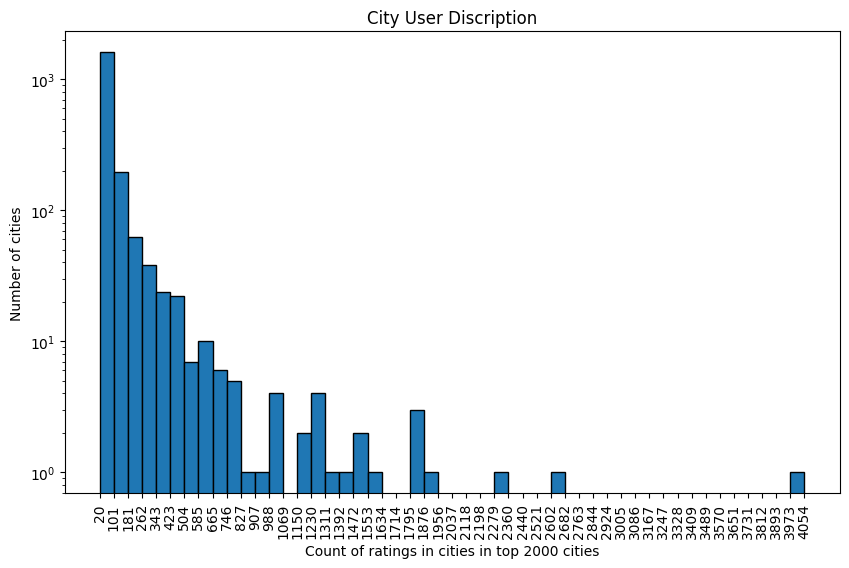

most_active_cities:                 count
city                
london          4054
barcelona       2645
toronto         2282
madrid          1912
sydney          1863
melbourne       1843
portland        1816
vancouver       1632
chicago         1537
seattle         1500
new york        1433
milano          1332
san diego       1300
berlin          1290
san francisco   1282
ottawa          1266
houston         1212
paris           1169
los angeles     1018
austin          1013
roma            1001


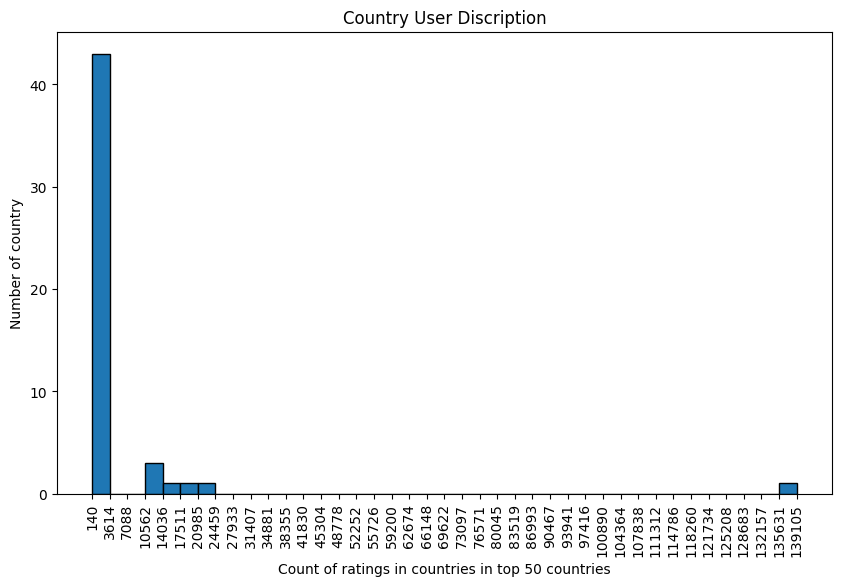

most_active_countries:                    count
country                
 usa             139105
 canada           21528
 united kingdom   18225
 germany          17002
 spain            13078
 australia        11702
 italy            11222
 france            3435
 portugal          3300
 new zealand       3056
 netherlands       2997
 switzerland       1732
 brazil            1667
 china             1455
 sweden            1398
 india             1262
 austria           1128
 malaysia          1084
 argentina         1074
 finland            917
 singapore          863
 belgium            814
 mexico             800
 denmark            797
 ireland            733
 philippines        696
time: 1.68 s (started: 2023-10-31 09:18:15 +00:00)


In [ ]:
users_EDA = users[~((users['city'] == 'n/a' ) | (users['city'] == '' ) |(users['state'] == 'n/a' ) | (users['country'] == 'n/a' )| (users['country'] == '' ))]
users_EDA_cities = users_EDA.groupby('city').size().to_frame('count').sort_values('count', ascending=False)
most_active_cities = users_EDA_cities[users_EDA_cities['count']>1000]

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(users_EDA_cities['count'][:2000],log=True,edgecolor='black',bins=50)
plt.xlabel('Count of ratings in cities in top 2000 cities')
plt.xticks(bins, rotation=90)
plt.ylabel('Number of cities')
plt.title('City User Discription')
plt.show()

print('most_active_cities: ',most_active_cities)

users_EDA_countries = users_EDA.groupby('country').size().to_frame('count').sort_values('count', ascending=False)
most_active_countries = users_EDA_countries[users_EDA_countries['count']>500]

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(users_EDA_countries['count'][:50], bins = 40,edgecolor='black')
plt.xlabel('Count of ratings in countries in top 50 countries')
plt.xticks(bins, rotation=90)
plt.ylabel('Number of country')
plt.title('Country User Discription')
plt.show()

print('most_active_countries: ',most_active_countries)

### Review EDA

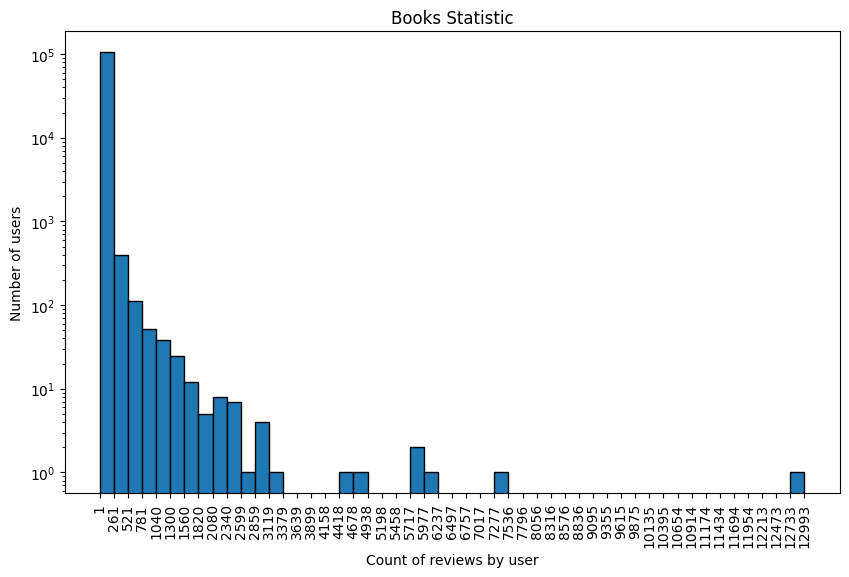

Total count of rated books:  311845
Maximum count of ratings on a book:  2502
Minimum count of ratings on a book:  1
Median count of ratings on a book:  1.0
Count of books with higher than or equal to 10 ratings:  18077
Count of books with higher than or equal to 5 ratings:  41983
Count of books with higher than or equal to 2 ratings:  132801
time: 3.12 s (started: 2023-10-31 09:18:17 +00:00)


In [ ]:
user_rating_count =  ratings.groupby('user_id').size().to_frame('count').sort_values('count', ascending=False)
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(user_rating_count['count'], log=True,bins=50,edgecolor='black')
plt.xlabel('Count of reviews by user')

plt.xticks(bins, rotation=90)
plt.ylabel('Number of users')
plt.title('Books Statistic')
plt.show()

grouped_be_isbn_df= ratings[['isbn']].groupby('isbn')


print('Total count of rated books: ',grouped_be_isbn_df.size().shape[0])
print('Maximum count of ratings on a book: ', grouped_be_isbn_df.size().max())
print('Minimum count of ratings on a book: ', grouped_be_isbn_df.size().min())
print('Median count of ratings on a book: ',grouped_be_isbn_df.size().median())
print('Count of books with higher than or equal to 10 ratings: ',len(grouped_be_isbn_df.size()[grouped_be_isbn_df.size()>=10]))
print('Count of books with higher than or equal to 5 ratings: ',len(grouped_be_isbn_df.size()[grouped_be_isbn_df.size()>=5]))
print('Count of books with higher than or equal to 2 ratings: ',len(grouped_be_isbn_df.size()[grouped_be_isbn_df.size()>=2]))

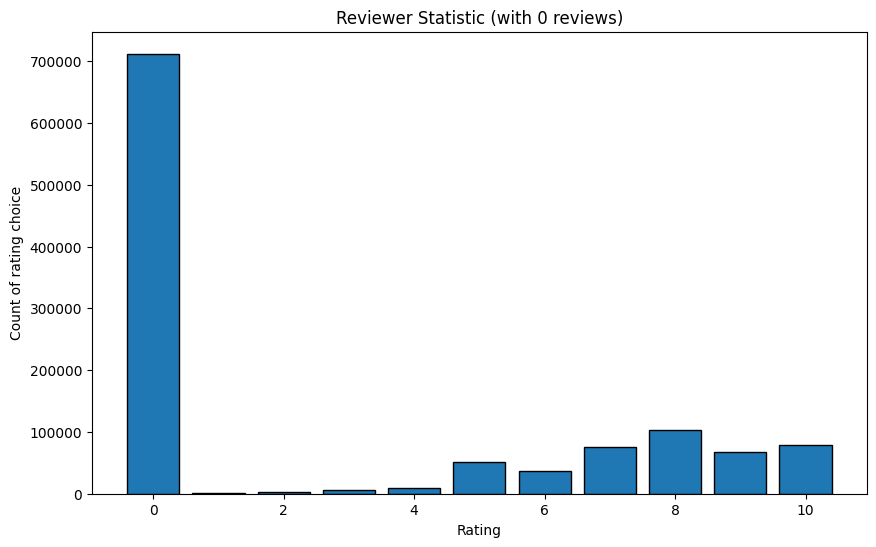

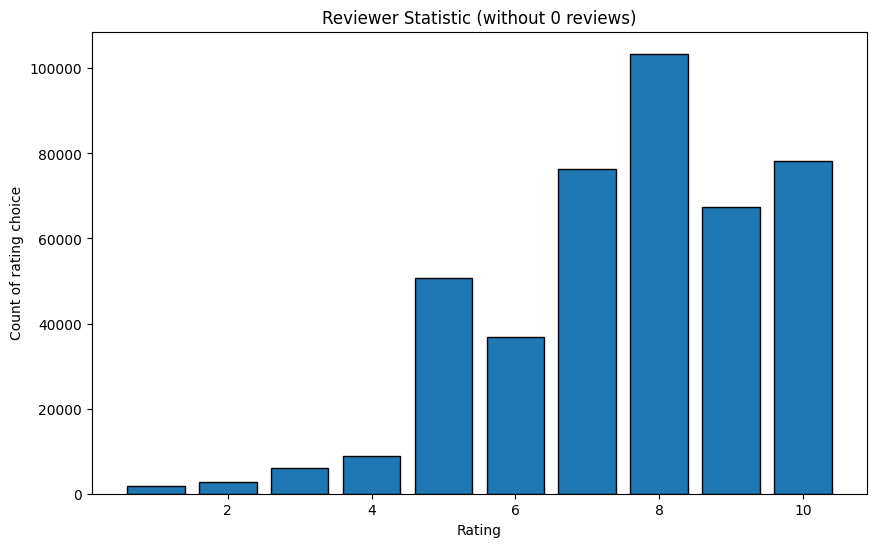

Total count of reviewers:  105283
Maximum count of reviews by a reviewer:  12993
Minimum count of reviews by a reviewer:  1
Median count of ratings on a book:  1.0
Count of reviewers with higher than or equal to 10 ratings:  13092
Count of reviewers with higher than or equal to 5 ratings:  22813
Count of reviewers with higher than or equal to 2 ratings:  46104
Ratio of zero ratings: 0.6222674038632924
Median, mean and std of the non zero ratings: (8.0, 7.599959289509416, 1.8436094031022943)
Users with only 0 ratings ever: 27478


<ipython-input-48-29f2e9915200>:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ratings = ratings[ratings['user_id'].isin(zero_reviewer_id)][~ratings['user_id'].isin(not_useful_users)]


time: 3.25 s (started: 2023-10-31 09:18:20 +00:00)


In [ ]:
grouped_by_user_id_df= ratings[['user_id']].groupby('user_id')


unique_rating_count = ratings.groupby('rating').size().to_frame('count').sort_values('count', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(unique_rating_count.index, unique_rating_count['count'], edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count of rating choice')
plt.title('Reviewer Statistic (with 0 reviews)')
plt.show()


unique_rating_count = unique_rating_count[unique_rating_count.index!=0]
plt.figure(figsize=(10, 6))
plt.bar(unique_rating_count.index, unique_rating_count['count'], edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count of rating choice')
plt.title('Reviewer Statistic (without 0 reviews)')
plt.show()

print('Total count of reviewers: ',grouped_by_user_id_df.size().shape[0])
print('Maximum count of reviews by a reviewer: ', grouped_by_user_id_df.size().max())
print('Minimum count of reviews by a reviewer: ', grouped_by_user_id_df.size().min())
print('Median count of ratings on a book: ',grouped_by_user_id_df.size().median())
print('Count of reviewers with higher than or equal to 10 ratings: ',len(grouped_by_user_id_df.size()[grouped_by_user_id_df.size()>=10]))
print('Count of reviewers with higher than or equal to 5 ratings: ',len(grouped_by_user_id_df.size()[grouped_by_user_id_df.size()>=5]))
print('Count of reviewers with higher than or equal to 2 ratings: ',len(grouped_by_user_id_df.size()[grouped_by_user_id_df.size()>=2]))

ratio_zero = ratings[ratings['rating']==0].shape[0]/ratings.shape[0]
print(f'Ratio of zero ratings: {ratio_zero}')
non_zero_median = ratings[ratings['rating']!=0]['rating'].median()
non_zero_mean = ratings[ratings['rating']!=0]['rating'].mean()
non_zero_std = ratings[ratings['rating']!=0]['rating'].std()

print(f'Median, mean and std of the non zero ratings: {non_zero_median, non_zero_mean, non_zero_std}')


zero_reviewer_id = ratings[ratings['rating'] == 0]['user_id']
zero_reviewer_unique_rating_count = ratings[ratings['user_id'].isin(zero_reviewer_id)].groupby(['user_id'])['rating'].nunique().to_frame('unique_count')
print('Users with only 0 ratings ever:', zero_reviewer_unique_rating_count.groupby('unique_count').size()[1])
not_useful_users = zero_reviewer_unique_rating_count[zero_reviewer_unique_rating_count['unique_count'] ==1].index
ratings = ratings[ratings['user_id'].isin(zero_reviewer_id)][~ratings['user_id'].isin(not_useful_users)]

## Post EDA Cleanup

In [ ]:
ratings = ratings[ratings['rating']!=0]
isbn_title_map = dict(zip(books['isbn'], books['book_title']))
title_isbn_map = {v:k for k,v in isbn_title_map.items()}

time: 960 ms (started: 2023-10-31 09:18:24 +00:00)


# Colaberative Methods

## Colaborative Filtering

### Training Design

In [ ]:
train_similarity_matrix = 0

if train_similarity_matrix == 1:
  # Configs
  user_rating_threshold = 3
  book_rating_threshold = 3

  # Fetch Name
  ratings_with_name = ratings.merge(books,on='isbn')
  ratings_with_name.head()
  ratings_with_name = ratings_with_name[['isbn','user_id','rating', 'book_title']]


  x = ratings_with_name.groupby('user_id').count()['rating'] > user_rating_threshold
  above_threshold_users = x[x].index
  filtered_rating = ratings_with_name[ratings_with_name['user_id'].isin(above_threshold_users)]

  y = filtered_rating.groupby('isbn').count()['rating']>= book_rating_threshold
  famous_books = y[y].index
  final_ratings = filtered_rating[filtered_rating['isbn'].isin(famous_books)]

  pt = final_ratings.pivot_table(index='isbn',columns='user_id',values='rating')
  pt.fillna(0,inplace=True)

  similarity_scores = cosine_similarity(pt)
  similarity_scores.shape


  file_name = "similarity_scores.pkl"
  import pickle
  with open(file_name, 'wb') as file:
      pickle.dump(similarity_scores, file)

time: 1.34 ms (started: 2023-10-31 09:18:25 +00:00)


In [ ]:
import pickle
file_name = "/content/drive/Shareddrives/Books_Challenge/similarity_scores.pkl"
with open(file_name, 'rb') as file:
    similarity_scores = pickle.load(file)
file_name = "/content/drive/Shareddrives/Books_Challenge/pt.pkl"
with open(file_name, 'rb') as file:
    pt = pickle.load(file)

time: 29 s (started: 2023-10-31 09:18:25 +00:00)


### Sample Colaborative Filtering API

In [ ]:
get_best_book_cosine_colab("Animal Farm")

"Harry Potter and the Philosopher's Stone"

time: 16.9 ms (started: 2023-10-31 10:08:30 +00:00)


## Graph with Colaberative Filtering

### Community Data Load

In [ ]:
final_community_df = pd.read_csv('/content/drive/Shareddrives/Books_Challenge/Community.csv').drop('Unnamed: 0', axis = 1)

time: 246 ms (started: 2023-10-31 09:18:54 +00:00)


### Sample Graph with Colaberative Filtering API

In [ ]:
get_best_book_graph_with_cosine_colab('Animal Farm')

'1984'

time: 54.9 ms (started: 2023-10-31 09:18:54 +00:00)


# Content Based Methods (BERT Implementation)

### Filtering Condition

In [ ]:
isbn_filter = ratings.groupby('isbn').size().to_frame('Count').reset_index()
isbn_filter = isbn_filter[isbn_filter.Count > 10]['isbn']
reference_books_df = books[books['isbn'].isin( isbn_filter)].reset_index(drop = 1)
reference_books_df

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,book_title_identifier
0,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,thekitchengodswifetan
1,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,http://images.amazon.com/images/P/0671870432.0...,pleadingguiltyturow
2,1558746218,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,1998,Health Communications,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,http://images.amazon.com/images/P/1558746218.0...,asecondchickensoupforthewomanssoulchickensoupf...
3,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,thetestamentgrisham
4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,belovedplumecontemporaryfictionmorrison
...,...,...,...,...,...,...,...,...,...
4054,0786889780,First Person Plural : My Life as a Multiple,Cameron West,1999,Hyperion,http://images.amazon.com/images/P/0786889780.0...,http://images.amazon.com/images/P/0786889780.0...,http://images.amazon.com/images/P/0786889780.0...,firstpersonpluralmylifeasamultiplewest
4055,3522128001,Die unendliche Geschichte: Von A bis Z,Michael Ende,1979,Thienemann,http://images.amazon.com/images/P/3522128001.0...,http://images.amazon.com/images/P/3522128001.0...,http://images.amazon.com/images/P/3522128001.0...,dieunendlichegeschichtevonabiszende
4056,0330349678,With Nails the Film Diaries of Richard E,Richard E Grant,0,Pan Books Ltd,http://images.amazon.com/images/P/0330349678.0...,http://images.amazon.com/images/P/0330349678.0...,http://images.amazon.com/images/P/0330349678.0...,withnailsthefilmdiariesofrichardegrant
4057,0892967811,Cyanide Wells,Marcia Muller,2003,Mysterious Press,http://images.amazon.com/images/P/0892967811.0...,http://images.amazon.com/images/P/0892967811.0...,http://images.amazon.com/images/P/0892967811.0...,cyanidewellsmuller


time: 865 ms (started: 2023-10-31 09:18:54 +00:00)


### Pretrain Initialization

In [ ]:
!pip install transformers
import torch
from transformers import BertTokenizer, BertModel
import pickle
# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
# % matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

time: 17.5 s (started: 2023-10-31 09:18:55 +00:00)


### Load Model

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

# Assuming you have a GPU available, you can set your device like this
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model.to(device)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

time: 4.58 s (started: 2023-10-31 09:19:12 +00:00)


### Tokenize Data

In [ ]:
train_embeddings = 0
output_file = 'book_title_tokenized_embeddings.pkl'
# input_file = 'book_title_tokenized_embeddings.pkl'
input_file = '/content/drive/Shareddrives/Books_Challenge/book_title_tokenized_embeddings_pd_series.pkl'

time: 571 µs (started: 2023-10-31 09:19:17 +00:00)


In [ ]:
if train_embeddings==1:
  marked_text = "[CLS] " + books[books['isbn'].isin( isbn_filter)].book_title  + " [SEP]"
  marked_text = marked_text.reset_index(drop=True)
  marked_text_embedded = marked_text.apply(lambda x: tokenizer.tokenize(x))
  # Embedding into IDs
  marked_text_segments_ids = marked_text_embedded.apply(lambda x: [1] * len(x))
  marked_text_embedded_ids = marked_text_embedded.apply(lambda x : tokenizer.convert_tokens_to_ids(x))
  # Tensorizing Tokens
  tokens_tensor = marked_text_embedded_ids.apply(lambda x: torch.tensor([x]))
  segments_tensors = marked_text_segments_ids.apply(lambda x: torch.tensor([x]))
  # Creating one large list of all tokens to get preds
  tokens_list = [tokens_tensor[i] for i in range(len(tokens_tensor))]
  segments_list = [segments_tensors[i] for i in range(len(segments_tensors))]

time: 1.25 ms (started: 2023-10-31 09:19:17 +00:00)


In [ ]:
# # Embedding into IDs
# marked_text_segments_ids = marked_text_embedded.apply(lambda x: [1] * len(x))
# marked_text_embedded_ids = marked_text_embedded.apply(lambda x : tokenizer.convert_tokens_to_ids(x))
# # Tensorizing Tokens
# tokens_tensor = marked_text_embedded_ids.apply(lambda x: torch.tensor([x]))
# segments_tensors = marked_text_segments_ids.apply(lambda x: torch.tensor([x]))
# # Creating one large list of all tokens to get preds
# tokens_list = [tokens_tensor[i] for i in range(len(tokens_tensor))]
# segments_list = [segments_tensors[i] for i in range(len(segments_tensors))]

time: 351 µs (started: 2023-10-31 09:19:17 +00:00)


### Generate Encodings

In [ ]:
if train_embeddings==1:
  with torch.no_grad():
      all_hidden_states = []
      for i,v in enumerate(zip(tokens_list, segments_list)):
          (tokens, segments) = v
          outputs = model(tokens.to(device), segments.to(device))

          # Evaluating the model will return hidden states from all layers.
          hidden_states = outputs[2]

          # Append the hidden states for this row to the list
          all_hidden_states.append(hidden_states)
          if i%1000 == 0:
            print(f'Completed % ={i*100/len(tokens_list)}')

  filename = "hidden_states.pkl"
  # Pickle and save the data
  with open(filename, "wb") as file:
      pickle.dump(all_hidden_states, file)
  all_hidden_states_embeddings = []
  for hidden_states in all_hidden_states:
    token_vecs = hidden_states[-2][0]
    sentence_embedding = torch.mean(token_vecs, dim=0)
    all_hidden_states_embeddings.append(sentence_embedding)
  all_hidden_states_embeddings = torch.stack(all_hidden_states_embeddings)
  all_hidden_states_embeddings_df = pd.DataFrame(all_hidden_states_embeddings.cpu()).set_index(reference_books_df.isbn)
  all_hidden_states_embeddings_df.to_pickle('all_hidden_states_embeddings_df.pkl')

time: 1.31 ms (started: 2023-10-31 09:19:17 +00:00)


### BERT Utils

In [ ]:
all_hidden_states_embeddings_df = pd.read_pickle('/content/drive/Shareddrives/Books_Challenge/all_hidden_states_embeddings_df_large.pkl')

time: 374 ms (started: 2023-10-31 09:19:17 +00:00)


In [ ]:
def return_embedding(  query = "Atomic Physics"):

  marked_text = "[CLS] " + query + " [SEP]"
  marked_text_embedded =  tokenizer.tokenize(marked_text)
  # Embedding into IDs
  marked_text_segments_ids =  [1] * len(marked_text_embedded)
  marked_text_embedded_ids = tokenizer.convert_tokens_to_ids(marked_text_embedded)
  # Tensorizing Tokens
  tokens_tensor = torch.tensor([marked_text_embedded_ids])
  segments_tensors = torch.tensor([marked_text_segments_ids])
  with torch.no_grad():
        outputs = model(tokens_tensor.to(device), segments_tensors.to(device))

        # Evaluating the model will return hidden states from all layers.
        hidden_states = outputs[2]
  token_vecs = hidden_states[-2][0]
  sentence_embedding = torch.mean(token_vecs, dim=0)

  return sentence_embedding.cpu()

time: 2.16 ms (started: 2023-10-31 09:19:18 +00:00)


In [ ]:
def return_cosine_similarity(query =  "Atomic Physics", all_hidden_states_embeddings_df= all_hidden_states_embeddings_df):

  A = return_embedding(query )
  norm_A = np.linalg.norm(A)
  A_normalized = A / norm_A
  B = all_hidden_states_embeddings_df.to_numpy()
  norm_B = np.linalg.norm(B, axis=1, keepdims=True)
  B_normalized = B / norm_B
  cosine_sim = np.dot(B_normalized, A_normalized)
  return cosine_sim

time: 816 µs (started: 2023-10-31 09:19:18 +00:00)


In [ ]:
def return_best_book(query =  "Atomic Physics"):
  cosine_sim = return_cosine_similarity(query)
  if reference_books_df.book_title.str.contains(query).sum() ==0:

    i = np.argmax(cosine_sim)
    return reference_books_df.iloc[i]
  else:
    sorted_indices = np.argsort(cosine_sim)
    second_highest_index = sorted_indices[-2]
    return(reference_books_df.iloc[second_highest_index])

time: 1.85 ms (started: 2023-10-31 09:19:18 +00:00)


In [ ]:
def get_best_book_bert_content(query =  "Atomic Physics"):
  try:
    cosine_sim = return_cosine_similarity(query)
    # print(cosine_sim)
    if reference_books_df.book_title.str.contains(query).sum() ==0:

      i = np.argmax(cosine_sim)
      return reference_books_df.iloc[i]['book_title']
    else:
      sorted_indices = np.argsort(cosine_sim)
      second_highest_index = sorted_indices[-2]
      return(reference_books_df.iloc[second_highest_index]['book_title'])
  except:return''



time: 832 µs (started: 2023-10-31 09:19:18 +00:00)


In [ ]:

def get_best_book_big_bert_content(query =  "Atomic Physics"):
  try:
    cosine_sim = return_cosine_similarity(query)
    # print(cosine_sim)
    if big_reference_books_df.book_title.str.contains(query).sum() ==0:

      i = np.argmax(cosine_sim)
      return big_reference_books_df.iloc[i]['book_title']
    else:
      sorted_indices = np.argsort(cosine_sim)
      second_highest_index = sorted_indices[-2]
      return(big_reference_books_df.iloc[second_highest_index]['book_title'])
  except:return''


time: 14.1 ms (started: 2023-10-31 09:19:18 +00:00)


### Sample BERT API

In [ ]:
get_best_book_big_bert_content('Vaclav')

'Rusalka'

time: 479 ms (started: 2023-10-31 10:18:34 +00:00)


# Content Based With Colaborative Filtering

## Data Loading

In [ ]:
colab_filtering_embeddings = pd.read_pickle('/content/drive/Shareddrives/Books_Challenge/pt.pkl')
all_hidden_states_embeddings = pd.read_pickle('/content/drive/Shareddrives/Books_Challenge/all_hidden_states_embeddings_df.pkl')
colab_filtering_isbns = set(colab_filtering_embeddings.index)
bert_filtering_isbns = set(all_hidden_states_embeddings.index)
print(f'Number of books embedded in colaborative filtering: {len(colab_filtering_isbns)}')
print(f'Number of books embedded in content filtering: {len(bert_filtering_isbns)}')
intersection_set = colab_filtering_isbns.intersection(bert_filtering_isbns)
print(f'Intersection of both filters: {len(intersection_set)}')

Number of books embedded in colaborative filtering: 9882
Number of books embedded in content filtering: 4059
Intersection of both filters: 4056
time: 2.66 s (started: 2023-10-31 09:19:18 +00:00)


## Merge Similarity Generator

In [ ]:
colab_filtering_cosine_matrix = colab_filtering_embeddings.loc[list(intersection_set)]
bert_filtering_cosine_matrix = all_hidden_states_embeddings.loc[list(intersection_set)]
bert_filtering_cosine_matrix = pd.DataFrame(
    cosine_similarity(bert_filtering_cosine_matrix),
             index =list(intersection_set),
             columns =list(intersection_set))

colab_filtering_cosine_matrix = pd.DataFrame(
    cosine_similarity(colab_filtering_cosine_matrix),
             index =list(intersection_set),
             columns =list(intersection_set))
colab_filter_weight = 0.9
bert_filter_weight = 0.1


joint_similarity_matrix = colab_filtering_cosine_matrix*colab_filter_weight + \
bert_filtering_cosine_matrix*bert_filter_weight

time: 11.8 s (started: 2023-10-31 09:19:21 +00:00)


In [ ]:
joint_similarity_matrix

,0449005909,0345434471,0060987529,1885171080,0140430725,0679429883,0446364703,0399144463,0425192733,1853260150,...,0399145087,0425155404,0380012863,0140272658,0553294903,0060558199,0385475772,0064402053,0375724370,0312890540
0449005909,1.000000,0.064025,0.116444,0.054661,0.045274,0.113893,0.057449,0.092971,0.055355,0.103421,...,0.095619,0.095582,0.048572,0.045057,0.162569,0.126292,0.126565,0.048529,0.053799,0.057244
0345434471,0.064025,1.000000,0.058472,0.059204,0.051508,0.056537,0.061752,0.052666,0.060214,0.053119,...,0.061686,0.057989,0.052888,0.053241,0.061265,0.058896,0.053925,0.054719,0.057537,0.061369
0060987529,0.116444,0.058472,1.000000,0.069074,0.065139,0.092899,0.108517,0.091678,0.091045,0.142768,...,0.059296,0.063995,0.070184,0.052523,0.081177,0.145080,0.101559,0.065086,0.065465,0.062601
1885171080,0.054661,0.059204,0.069074,1.000000,0.101777,0.069212,0.072662,0.179997,0.070203,0.061385,...,0.068219,0.048940,0.051034,0.064886,0.071122,0.076588,0.078012,0.064962,0.065343,0.063061
0140430725,0.045274,0.051508,0.065139,0.101777,1.000000,0.056834,0.062929,0.064105,0.070769,0.080331,...,0.074149,0.040385,0.051720,0.135213,0.054344,0.061735,0.065862,0.062438,0.070692,0.064043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0060558199,0.126292,0.058896,0.145080,0.076588,0.061735,0.129690,0.079818,0.100465,0.075850,0.210900,...,0.081377,0.094048,0.053842,0.054672,0.117193,1.000000,0.144651,0.065372,0.069638,0.066568
0385475772,0.126565,0.053925,0.101559,0.078012,0.065862,0.133770,0.071865,0.094466,0.071573,0.120195,...,0.081720,0.096519,0.048270,0.060524,0.126909,0.144651,1.000000,0.060345,0.065698,0.067041
0064402053,0.048529,0.054719,0.065086,0.064962,0.062438,0.067053,0.060575,0.060889,0.061696,0.061681,...,0.056797,0.040507,0.051027,0.049962,0.059070,0.065372,0.060345,1.000000,0.062543,0.061896
0375724370,0.053799,0.057537,0.065465,0.065343,0.070692,0.062534,0.067274,0.064445,0.075191,0.074009,...,0.056738,0.039945,0.050982,0.053595,0.059866,0.069638,0.065698,0.062543,1.000000,0.061487


time: 50.3 ms (started: 2023-10-31 09:19:33 +00:00)


## Merged Approach Utils

In [ ]:

def get_best_book_colab_with_content (query = 'Atomic Physics'):
  try:
    isbn = title_isbn_map[query]
    series = joint_similarity_matrix[isbn]
    return (isbn_title_map[series.sort_values().index[-2]])
  except:
    return ''

time: 748 µs (started: 2023-10-31 09:19:33 +00:00)


## Sample Merged Approach API

In [ ]:
get_best_book_colab_with_content("1984")

'Animal Farm'

time: 7.2 ms (started: 2023-10-31 09:19:33 +00:00)


# Performance Validation

In [ ]:
# n = 10
# top_users = ratings.groupby('user_id').size().sort_values(ascending=False).index[5:n+5].to_list()

time: 254 µs (started: 2023-10-31 09:19:33 +00:00)


In [ ]:
# ratings_with_name = ratings.merge(books,on='isbn')
# ratings_with_name = ratings_with_name[['isbn','user_id','rating', 'book_title']]
# top_users_ratings_with_name = ratings_with_name[ratings_with_name['user_id'].isin(top_users)][['user_id','book_title']]
# top_users_ratings_with_name = top_users_ratings_with_name.groupby('user_id').agg(['unique'])
# top_users_ratings_with_name = pd.DataFrame(top_users_ratings_with_name.to_records())
# top_users_ratings_with_name.set_axis(['User', 'Book'], axis=1,inplace=True)
# validation_data = top_users_ratings_with_name.explode('Book')
# # val_df = pd.read_pickle('/content/drive/Shareddrives/Books_Challenge/validation_data.pkl')

time: 336 µs (started: 2023-10-31 09:19:33 +00:00)


In [ ]:
# def return_set_stats(A, B):
#     TP_B = len(A.intersection(B))
#     B.discard(str(user))
#     Total_Preds = len(B)
#     FP_B = (len(B) - len(A.intersection(B)))
#     return int(TP_B),int(FP_B),Total_Preds


time: 685 µs (started: 2023-10-31 09:19:33 +00:00)


In [ ]:
# validation_data['cosine_colab'] = validation_data['Book'].apply(lambda x: get_best_book_cosine_colab(x))
# validation_data['graph_with_cosine_colab'] = validation_data['Book'].apply(lambda x: get_best_book_graph_with_cosine_colab(x))
# validation_data['bert_content'] =  validation_data['Book'].apply(lambda x: get_best_book_bert_content(x))
# validation_data['colab_with_content'] =  validation_data['Book'].apply(lambda x: get_best_book_colab_with_content(x))
# # validation_data

# file_name = "validation_data.pkl"
# import pickle
# with open(file_name, 'wb') as file:
#     pickle.dump(validation_data, file)

# val_df = validation_data
# list_of_stats = []
# val_df.reset_index(drop=True, inplace = True)
# for user in val_df.User.unique():
#     user_df = val_df[val_df['User'] == user]
#     number_of_samples = int(user_df.shape[0]/10)
#     sample = user_df.sample(number_of_samples)
#     A = set(str(user)+sample.Book)
#     B = set(str(user)+sample.cosine_colab)
#     TP_B,FP_B,Total_Preds = return_set_stats(A,B)
#     list_of_stats.append(['M1',TP_B,FP_B,Total_Preds])


#     C = set(str(user)+sample.graph_with_cosine_colab)
#     TP_B,FP_B,Total_Preds = return_set_stats(A,C)
#     list_of_stats.append(['M2',TP_B,FP_B,Total_Preds])


#     # D = set(str(user)+sample.bert_content)
#     # TP_B,FP_B,Total_Preds = return_set_stats(A,D)
#     # list_of_stats.append(['M3',TP_B,FP_B,Total_Preds])

#     E = set(str(user)+sample.colab_with_content)
#     TP_B,FP_B,Total_Preds = return_set_stats(A,E)
#     list_of_stats.append(['M4',TP_B,FP_B,Total_Preds])




# val_results_df = pd.DataFrame(np.array(list_of_stats),columns = ['Method', 'True_Pos', 'False_Pos', 'Count'])

time: 361 µs (started: 2023-10-31 09:19:33 +00:00)


In [ ]:
# val_results_df

time: 298 µs (started: 2023-10-31 09:19:33 +00:00)


In [ ]:
toc = time.time()
net_execution_time =  toc - tic

time: 565 µs (started: 2023-10-31 09:19:33 +00:00)
